# EE519 — Lecture 9 (Linear Prediction / LPC) — Notebook 9.2
## Levinson–Durbin + PARCOR (fixed imports)

**Theme:** Efficient LPC solver + stability intuition.

---
### 🧭 In-class workflow
1. Read the short explanation above each code cell
2. Predict what you expect to see
3. Run
4. Save at least one key figure

### 🧯 Debugging quick panel (“If you see X, do Y”)
- **Module import error** → run the “Environment & imports” cell again; restart kernel if needed.
- **Audio playback is silent** → re-record closer to mic; ensure waveform peak is not near zero.
- **`frame_selections` missing** → go back to Notebook 9.0 and define time ranges / frames, then save to manifest.
- **LPC envelope looks too wiggly** → reduce order `p` (try 10–16).
- **LPC envelope looks too flat** → increase order `p` slightly or pick a steadier vowel region.
- **FFT vs LPC don’t “overlay”** → use the provided “normalize-to-peak” plot (shape comparison) cell.


### 🎯 Learning goals
- Run end-to-end without manual clip/frame prompts (assumes Notebook 9.0 selections saved)
- Save key plots to the project folder


## 0. Environment & imports (run this first)

This notebook uses:
- `numpy`, `matplotlib`
- `scipy` (signal + linalg)
- optional: `sounddevice` (recording)
- optional: `sklearn` (mini ML demo only)

If any import fails, the cell prints what to do next.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Core scipy imports (required)
try:
    import scipy.signal as sig
    import scipy.linalg as la
    import scipy.io.wavfile as wavfile
    SCIPY_OK = True
    print("scipy imports: ✅")
except Exception as e:
    SCIPY_OK = False
    print("scipy imports: ❌")
    print("Error:", e)

# Optional recording
try:
    import sounddevice as sd
    HAS_SD = True
    print("sounddevice: ✅ (recording enabled)")
except Exception as e:
    HAS_SD = False
    print("sounddevice: ❌ (recording disabled)")

from pathlib import Path
import json, os, time
from IPython.display import Audio, display


scipy imports: ✅
sounddevice: ✅ (recording enabled)


## 1. Project + manifest workflow (same spirit as Lectures 7/8)

We will use one project folder:
```
EE519_L9_Project/
  recordings/
  figures/
  features/
  cache/
  manifest.json
```

✅ You can re-run this cell any time safely.


In [2]:
PROJECT_DIR = Path("EE519_L9_Project")
REC_DIR = PROJECT_DIR / "recordings"
FIG_DIR = PROJECT_DIR / "figures"
FEAT_DIR = PROJECT_DIR / "features"
CACHE_DIR = PROJECT_DIR / "cache"

for d in [PROJECT_DIR, REC_DIR, FIG_DIR, FEAT_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text())
    return {"clips": [], "meta": {"created": time.time(), "course":"EE519", "lecture":9}}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2))

manifest = load_manifest()
print("Manifest clips:", len(manifest["clips"]))
print("Project dir:", PROJECT_DIR.resolve())


Manifest clips: 9
Project dir: C:\Users\K\Documents\usc\ee519\ee519-lecture\lecture10\EE519_L9_Project


## 2. Utilities (audio I/O, framing, STFT, saving figures)

These helpers are used throughout Lecture 9 notebooks.


In [3]:
def read_wav(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)
    if np.max(np.abs(x)) > 1.5:
        x = x / 32768.0
    return fs, x

def peak_normalize(x, target=0.95):
    m = np.max(np.abs(x)) + 1e-12
    return x * (target / m)

def play_audio(x, fs, label=""):
    print(label, f"(fs={fs}, length={len(x)/fs:.2f}s)")
    display(Audio(x, rate=fs))

def savefig(name):
    out = FIG_DIR / name
    plt.savefig(out, dpi=180, bbox_inches="tight")
    print("Saved:", out)

def hann(N):
    return np.hanning(N).astype(np.float32)

def frame_signal(x, N, H):
    if len(x) < N:
        raise ValueError("Signal shorter than frame length N.")
    num = 1 + (len(x) - N) // H
    frames = np.stack([x[i*H:i*H+N] for i in range(num)], axis=0)
    return frames

def stft_scipy(x, fs, win_ms=25, hop_ms=10, nfft=None, window="hann"):
    N = int(win_ms * 1e-3 * fs)
    H = int(hop_ms * 1e-3 * fs)
    if nfft is None:
        nfft = 1 << int(np.ceil(np.log2(N)))
    f, t, Z = sig.stft(x, fs=fs, window=window, nperseg=N, noverlap=N-H, nfft=nfft, boundary=None, padded=False)
    return f, t, Z, N, H

def plot_spectrogram(Z, fs, title, fmax=8000):
    S = 20*np.log10(np.abs(Z)+1e-12)
    plt.figure(figsize=(10,4))
    plt.imshow(S, origin="lower", aspect="auto",
               extent=[0, Z.shape[1], 0, fs/2])
    plt.ylim([0, fmax])
    plt.colorbar(label="dB")
    plt.title(title)
    plt.xlabel("Frame index")
    plt.ylabel("Frequency (Hz)")
    plt.show()


## LPC core functions (used in Notebooks 9.1–9.4)

### Important fix vs earlier versions
- `toeplitz` is in `scipy.linalg`, not `scipy.signal`.
- We therefore use `la.toeplitz` to avoid errors.

### Autocorrelation convention
We use a **biased** autocorrelation estimate:
\$
r[k] = \sum_{n=0}^{N-1-k} x[n]\,x[n+k]
\$

This is common in LPC autocorrelation method demonstrations.


In [4]:
def autocorr_biased(x, p):
    x = np.asarray(x, dtype=np.float64)
    r = np.zeros(p+1, dtype=np.float64)
    for k in range(p+1):
        r[k] = np.sum(x[:len(x)-k] * x[k:])
    return r

def lpc_autocorr_method(x, p):
    r = autocorr_biased(x, p)
    R = la.toeplitz(r[:-1])  # r[0..p-1]
    rhs = -r[1:]
    a = np.linalg.solve(R + 1e-12*np.eye(p), rhs)
    return a, r

def lpc_residual(x, a):
    A = np.concatenate([[1.0], a])
    e = sig.lfilter(A, [1.0], x)
    return e

def lpc_envelope_db(a, fs, nfft=4096):
    A = np.concatenate([[1.0], a])
    # Use freqz (stable, consistent)
    w, h = sig.freqz([1.0], A, worN=nfft, fs=fs)
    env_db = 20*np.log10(np.abs(h)+1e-12)
    return w, env_db

def fft_mag_db(x, fs, nfft=4096):
    X = np.fft.rfft(x, n=nfft)
    f = np.fft.rfftfreq(nfft, 1/fs)
    mag_db = 20*np.log10(np.abs(X)+1e-12)
    return f, mag_db

def normalize_to_peak(y_db):
    return y_db - np.max(y_db)


## Load a clip that already has `frame_selections`

✅ If this errors, go back to **Notebook 9.0**, select time ranges, and save to manifest.


In [5]:
def pick_first_clip_with_selections(prefer_label="vowel"):
    m = load_manifest()
    # first try preferred label
    for i,c in enumerate(m["clips"]):
        if c.get("label")==prefer_label and "frame_selections" in c and len(c["frame_selections"].get("vowel_frames",[]))>0:
            return i,c,m
    # otherwise any with selections
    for i,c in enumerate(m["clips"]):
        if "frame_selections" in c:
            return i,c,m
    raise RuntimeError("No clip has frame_selections. Run Notebook 9.0 to select and save frames.")

CLIP_IDX, clip, manifest = pick_first_clip_with_selections("vowel")
print("Using clip:", CLIP_IDX, clip["filename"], "| label:", clip.get("label"))

fs, x = read_wav(REC_DIR / clip["filename"])
x = peak_normalize(x)

sel = clip["frame_selections"]
WIN_MS = sel.get("win_ms", 25)
HOP_MS = sel.get("hop_ms", 10)
N = int(WIN_MS*1e-3*fs)
H = int(HOP_MS*1e-3*fs)

frames = frame_signal(x, N, H) * hann(N)[None,:]
vowel_frames = sel.get("vowel_frames", [])
fric_frames = sel.get("fricative_frames", [])
sil_frames = sel.get("silence_frames", [])

print("Counts | vowel:", len(vowel_frames), "fric:", len(fric_frames), "sil:", len(sil_frames))


Using clip: 6 F01_fric_s.wav | label: fricative
Counts | vowel: 30 fric: 10 sil: 4


## Levinson–Durbin + PARCOR (reflection coefficients)

We compute reflection coefficients \(k[m]\) and error energy \(E[m]\).


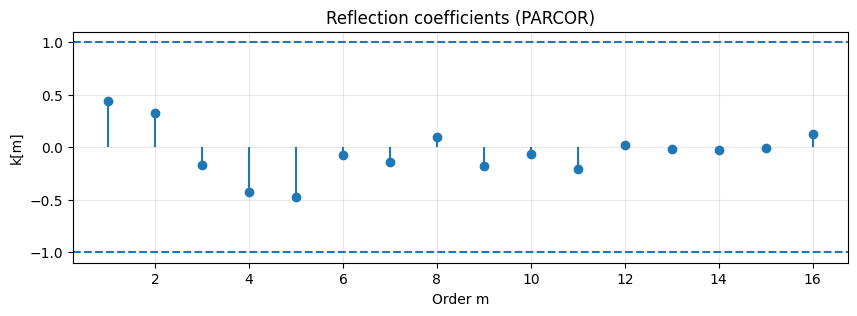

Saved: EE519_L9_Project\figures\L9_2_parcor_p16_frame30.png


<Figure size 640x480 with 0 Axes>

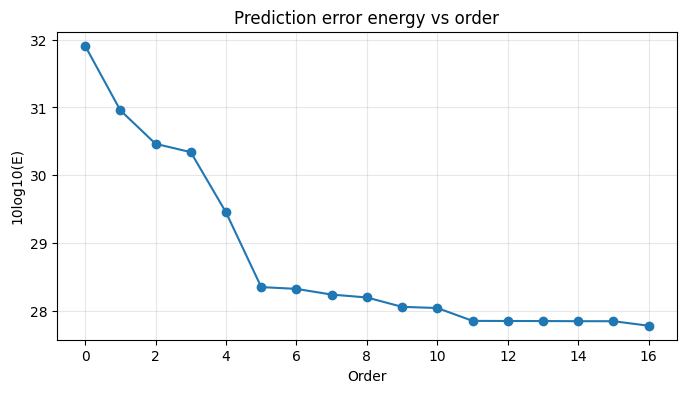

Saved: EE519_L9_Project\figures\L9_2_error_energy_vs_order_p16_frame30.png


<Figure size 640x480 with 0 Axes>

In [7]:
def levinson_durbin(r, p):
    a = np.zeros(p+1, dtype=np.float64)
    k = np.zeros(p+1, dtype=np.float64)
    E = np.zeros(p+1, dtype=np.float64)
    a[0] = 1.0
    E[0] = r[0] + 1e-12
    for m in range(1, p+1):
        acc = 0.0
        for i in range(1, m):
            acc += a[i] * r[m-i]
        k[m] = -(r[m] + acc) / (E[m-1] + 1e-12)
        a_new = a.copy()
        a_new[m] = k[m]
        for i in range(1, m):
            a_new[i] = a[i] + k[m] * a[m-i]
        a = a_new
        E[m] = (1.0 - k[m]**2) * E[m-1]
    return a, k, E

p = 16
r = autocorr_biased(x, p)
a_full, k, E = levinson_durbin(r, p)

FRAME_IDX=30


plt.figure(figsize=(10,3))
plt.stem(np.arange(1,p+1), k[1:], basefmt=" ")
plt.axhline(1.0, linestyle="--"); plt.axhline(-1.0, linestyle="--")
plt.title("Reflection coefficients (PARCOR)")
plt.xlabel("Order m"); plt.ylabel("k[m]")
plt.grid(True, alpha=0.3); plt.show()
savefig(f"L9_2_parcor_p{p}_frame{FRAME_IDX}.png")

plt.figure(figsize=(8,4))
plt.plot(np.arange(0,p+1), 10*np.log10(E+1e-12), marker="o")
plt.title("Prediction error energy vs order")
plt.xlabel("Order"); plt.ylabel("10log10(E)")
plt.grid(True, alpha=0.3); plt.show()
savefig(f"L9_2_error_energy_vs_order_p{p}_frame{FRAME_IDX}.png")


---
## ✅ What you learned (Notebook 9.2)
- You ran the LPC pipeline without fighting imports/toeplitz errors.
- You compared FFT vs LPC envelope using a **normalized-to-peak** plot (shape match).
- You saved figures into the project folder for later slides/reports.

## ➡️ What’s next
Proceed to **Notebook 9.3** (LPC envelope → formants).


---
## 🧠 Reflection (Notebook 9.2)

### What you learned
- How Levinson–Durbin exploits the Toeplitz structure for efficient LPC solving.
- What reflection coefficients (PARCOR) mean and why they relate to stability.
- How prediction error energy decreases as order increases (but not always “better”).

### Common mistakes to notice (and fix next time)
- Interpreting lower error energy as automatically “better” → can still overfit.
- Ignoring reflection coefficients that approach ±1 → indicates numerical instability / poor frame choice.
- Confusing `a[k]` (LPC coefficients) with `k[m]` (reflection coefficients).

### Reflective questions
1. What did you observe about error energy vs order? Was it monotonic? Why?
2. Did any reflection coefficients get close to ±1? If yes, what might that imply?
3. When would you prefer using Levinson–Durbin over a direct solve?
4. How would noise or nonstationarity affect PARCOR coefficients?

### Quick self-check
- [ ] I can explain what PARCOR coefficients represent.
- [ ] I can describe what “stable all-pole filter” means in this context.
- [ ] I saved the PARCOR stem plot.


### Answers

1. It seems to be monotonically decreasing since we aren't adding more coefficients.
2. 13 got the closest to 0.
3. In class we learned about Toeplitz matrices so Levinson-Durbin would be better for those.
4. This would likely cause variation between frames which could cause the coefficients to get closer to 0.